# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.476807,False,-1.191644
1,1.057640,True,5.880161
2,-0.268648,False,-1.685653
3,-0.131389,False,1.197483
4,-2.283468,True,0.843926
...,...,...,...
995,0.362441,True,5.934080
996,-2.215736,False,-2.508082
997,-1.276019,False,-2.924847
998,-0.402062,True,5.123236


<Axes: xlabel='v0'>

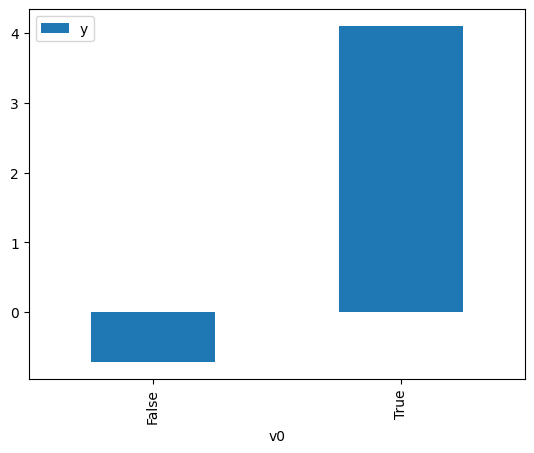

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

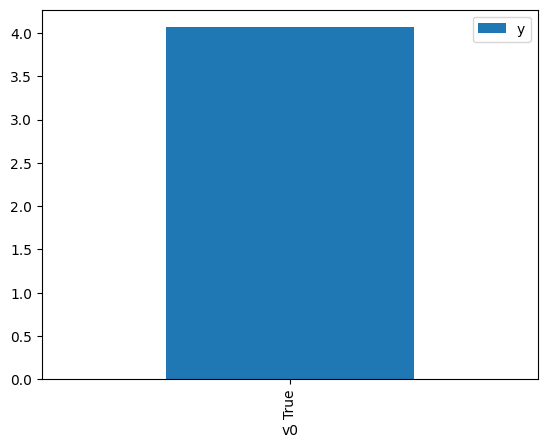

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.047284,False,-2.042036,0.555582,1.799913
1,-0.355461,False,-0.987704,0.520010,1.923041
2,1.379514,False,1.503049,0.430707,2.321763
3,-0.400060,False,-0.047781,0.522313,1.914561
4,-0.762710,False,-1.977228,0.540998,1.848436
...,...,...,...,...,...
995,-1.604232,False,-3.220356,0.583829,1.712831
996,1.020811,False,2.178356,0.448995,2.227199
997,-1.737562,False,-2.703650,0.590517,1.693431
998,-0.696335,False,0.282881,0.537585,1.860171


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.012764,True,6.130273,0.497710,2.009203
1,-0.477517,True,3.528024,0.473689,2.111089
2,-1.674832,True,3.128264,0.412626,2.423504
3,1.057640,True,5.880161,0.552890,1.808677
4,-0.018049,True,4.800644,0.497436,2.010308
...,...,...,...,...,...
995,0.751852,True,8.298227,0.537200,1.861506
996,-1.078428,True,3.297497,0.442827,2.258219
997,-0.684254,True,4.304839,0.463037,2.159657
998,-1.882613,True,3.274643,0.402245,2.486049


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              5851.
Date:                Wed, 29 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:34:54   Log-Likelihood:                         -1443.9
No. Observations:                1000   AIC:                                      2892.
Df Residuals:                     998   BIC:                                      2902.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8079      0.031     57.416      0.000       1.746       1.870
x2             4.9646      0.048    102.528      0.000       4.870       5.060
==============================================================================
Omnibus:                        1.371   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.504   Jarque-Bera (JB):                1.272
Skew:                          -0.083   Prob(JB):                        0.530
Kurtosis:                       3.053   Cond. No.                         1.64
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""